---

## Movie_Rating_Analysis



#### Data Manager

In [28]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpld3

import warnings
warnings.filterwarnings('ignore')
import datetime

import re
import sentiments_nrc
from sentiments_nrc import SENTIMENTS
from sentiments_nrc import EMOTIONS

In [2]:
reviews = pd.read_csv('../data/reviews.csv')
movies = pd.read_csv("../data/movies.dat", delimiter='\t')

In [3]:
### pre data cleaning for reviews data
reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]
reviews['review_date']=pd.to_datetime(reviews['review_date']).dt.date
reviews=reviews.drop(['link'], axis=1)

In [4]:
### pre data cleaning for movies data
movies= movies.drop(['imdbPictureURL','spanishTitle','rtPictureURL'], axis=1)
# drop movies with unknow or non-numeric values 
movies['rtAllCriticsRating'] = movies['rtAllCriticsRating'].apply(pd.to_numeric, errors='drop')
movies['rtAllCriticsNumReviews'] = movies['rtAllCriticsNumReviews'].apply(pd.to_numeric, errors = 'drop')
movies['rtAudienceRating'] = movies['rtAudienceRating'].apply(pd.to_numeric, errors= 'drop')

In [5]:
reviews.head(2)

,critic,fresh,imdb,publication,quote,review_date,rtid,title
0,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy Story
1,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy Story


In [6]:
movies.head(2)

,id,title,imdbID,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,rtAllCriticsNumRotten,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore
0,1,Toy story,114709,1995,toy_story,9.0,73.0,73,0,100,8.5,17,17,0,100,3.7,102338,81
1,2,Jumanji,113497,1995,1068044-jumanji,5.6,28.0,13,15,46,5.8,5,2,3,40,3.2,44587,61


In [7]:
sub_movies=movies[['title', 'imdbID', 'year', 'rtID','rtAllCriticsRating','rtAllCriticsNumReviews','rtAudienceNumRatings', 'rtAudienceScore']]

In [ ]:
sub_movies.head(1)

#### Visualization Manager I 

In [ ]:
# pip install mpld3

In [ ]:
# def draw_trend_line_median_year(sub_movies):
    
#     print('Please input the year range that you are interested in: ')
    
#     start_year = int(input())
#     end_year = int(input())
    
# #     movies_sub=movies[['title','imdbID']]
#     movie_review=reviews.merge(sub_movies, left_on='imdb', right_on='imdbID', how='inner')
#     movie_review = moview_review[movie_review['critic'] ==  'A.D. Murphy']
#     critic_median = movie_review.groupby('year')['rtAllCriticsRating'].median().reset_index()
#     year_median = sub_movies.groupby('year')['rtAllCriticsRating'].median().reset_index()
#     year_show = year_median[year_median['year'] >= start_year]
#     year_show = year_show[year_median['year'] <= end_year]
   
#     plt.plot(year_show['year'], year_show['rtAllCriticsRating'], color='lightblue')
#     plt.show()
    
# draw_trend_line_median_year(sub_movies)

In [25]:
import altair as alt
from vega_datasets import data


In [ ]:
selection = alt.selection_interval(bind='scales')

alt.Chart(cars).mark_line().encode(
    x='Horsepower:Q',
    y='Miles_per_Gallon:Q',
    color='Origin:N',
    tooltip='Name:N'
).add_selection(
    selection
)

Please input the year range that you are interested in: 
1970
1990


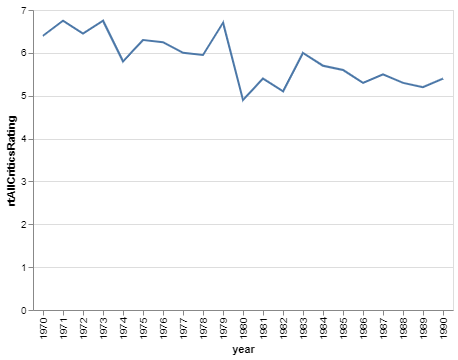

In [30]:
#### interactive one: draw the trendline of the median rating given a time interval 

def draw_trend_line_median_year(sub_movies):
    
    print('Please input the year range that you are interested in: ')
    

    start_year = int(input())
    end_year = int(input())
    
    year_median = sub_movies.groupby('year')['rtAllCriticsRating'].median().reset_index()
    year_show = year_median[year_median['year'] >= start_year]
    year_show = year_show[year_median['year'] <= end_year]
    
    
    selection = alt.selection_interval(bind='scales')

    chart = alt.Chart(year_show).mark_line().encode(
    x='year:N',
    y='rtAllCriticsRating:Q',
    tooltip='year:N').add_selection(selection)
   
    return chart
    

    
draw_trend_line_median_year(sub_movies)

In [54]:
def top5_critic_per_year(reviews,year):
    
    reviews['review_date'] = pd.to_datetime(reviews['review_date'])
    reviews['year'] = reviews['review_date'].dt.year
    Group_Aggregation = reviews[['critic', 'publication', 
                       'year', 'quote']].groupby(['critic','year']).agg({ 
                         'quote': ['count']}).reset_index()
    Group_Aggregation = Group_Aggregation[(Group_Aggregation['year'] == year)]
    Top_five = Group_Aggregation.sort_values(by=[('quote','count')], ascending = False)[:5].reset_index(drop =True)
    print(Top_five.columns)
#     Out = Top_five []
    
    return Top_five

In [62]:
top_critics = top5_critic_per_year(reviews,2008)
top_critics['critic']

MultiIndex(levels=[['quote', 'year', 'critic'], ['count', '']],
           codes=[[2, 1, 0], [1, 1, 0]])


0         Variety Staff
1    Jonathan Rosenbaum
2         Todd McCarthy
3             Dave Kehr
4       Richard Corliss
Name: critic, dtype: object

#### Visualization Manager II

In [135]:
#### interactive 2: sentiment analysis  for reviews of per critic 

### global variables 
movies_sub=movies[['title','imdbID']]
movie_review=reviews.merge(movies_sub, left_on='imdb', right_on='imdbID', how='inner')
movie_review=movie_review[['critic','publication','quote','review_date','title_x','imdb']]
EMOTIONS = ['positive', 'negative', 'anger', 
            'anticipation', 'disgust', 'fear', 
            'joy', 'sadness', 'surprise', 'trust']

# support function 1
def words_with_specific_emotion(list_of_split_words,emotion):
    '''Produce a list that include the words that contain a specific emotion
       Parameters: list_of_split_words (String): A list with split words 
                   emotion(string): the emotion words in EMOTIONS list
       Returns: list: the words in the string with one certain kind of emotion'''
    Look_Up=[SENTIMENTS.get(word) for word in list_of_split_words] #get the emotion list of every word in the list 
    Combine=list(zip(list_of_split_words,Look_Up)) # zip the emotion list with word in one list 
    Words_With_Specific_Emotion=[line[0] for line in Combine if line[1] is not None and line[1].get(emotion)==1 ]
    return Words_With_Specific_Emotion #find the words in a specific emotion

# support function 2
def words_list_for_each_emotion(Split_Test_String):
    '''Produce a disctionary with emotion words as keys and words list having that emotion as values
       Parameters: Split_Test_String (String): A list with split words
       Returns: list-the  most common words in the input list'''
    matching_words=[words_with_specific_emotion(Split_Test_String,emotion) for emotion in EMOTIONS]
    distinct_matching=[i for i in matching_words]
    return {emotion:matching_word for (emotion,matching_word) in zip(EMOTIONS,distinct_matching)}

# support function 3 
def get_common_words_list(wordlist):
    '''Produce a list with the most common words of the input list
       Parameters: wordlist (string): 
       Returns: dict: the key-values pairs of emotions word and its corresponding words in the string'''
    wordfreq=list(zip(wordlist,[wordlist.count(w) for w in wordlist]))
    wordfreq_sort=list(set(sorted(wordfreq,key=lambda freq: freq[1], reverse=True)))
    new_word_freq_sort=sorted(wordfreq_sort,key=lambda freq: freq[1], reverse=True)
    return [i[0] for i in new_word_freq_sort]

## main analysis function 
def analyze_quote(movie_review,criticname):
    
#     criticname = input("Please enter the Critic that you are interested: ")
    critic_quote=movie_review[['critic','quote']]
    quote = critic_quote[critic_quote['critic'] == criticname]
#     quote = []
#     for name in criticname:
#         sub_quote = critic_quote[critic_quote['critic'] == name]
#         quote.append(sub_quote)
#     quote = pd.DataFrame(quote) 
    
#     print
    #### cominbine quotes into one row 
    content=quote.groupby('critic')['quote'].apply(' '.join).reset_index()['quote']
    Split_String=re.split(r'\W+',content[0]) 
    lower_words=[word.lower() for word in Split_String] 
    length_filtered=[word for word in lower_words if len(word)>1]
    
    ### calculate total number or words
    Total_Words=len(length_filtered)
    Words_List_for_Each_Emotion=words_list_for_each_emotion(length_filtered)
    
    result_list=[]
    for i in EMOTIONS:
        result={}
        example_words=[get_common_words_list(value)[:3] for key,value in Words_List_for_Each_Emotion.items() if key==i]
        result['EMOTION']=i
        result['PERCENT']= len(Words_List_for_Each_Emotion[i])/Total_Words
        result['EXAMPLE WORDS']=example_words[0]
        result_list.append(result)
    result=sorted(result_list,key=lambda k:k['PERCENT'],reverse=True)
    
    return pd.DataFrame(result)
#     ### show the result in a table 
#     print("{0:<14} {1:<11} {2:35}".format('EMOTION','%WORDS','EXAMPLE WORDS'))
#     for line in result:
#         emotion=line['EMOTION']
#         words_percent=line['% WORDS']
#         format_words_percent='{:.2%}'.format(words_percent)
#         example_words=line['EXAMPLE WORDS']
#         top_example_words=','.join(example_words)
#         print("{0:<14} {1:<11} {2:35} ".format(emotion,format_words_percent,top_example_words))



In [136]:
### just for one year 

In [137]:
top_critics['critic']

0         Variety Staff
1    Jonathan Rosenbaum
2         Todd McCarthy
3             Dave Kehr
4       Richard Corliss
Name: critic, dtype: object

In [138]:
result = analyze_quote(movie_review,'Jonathan Rosenbaum')

In [139]:
result

,EMOTION,EXAMPLE WORDS,PERCENT
0,positive,"[good, feature, pretty]",0.075493
1,trust,"[good, pretty, director]",0.039973
2,negative,"[war, black, remains]",0.034851
3,joy,"[good, pretty, entertaining]",0.031956
4,anticipation,"[good, pretty, time]",0.030286
5,fear,"[war, remains, intelligence]",0.017593
6,surprise,"[good, entertainment, score]",0.015143
7,sadness,"[black, music, horror]",0.014030
8,anger,"[moral, horror, powerful]",0.013362
9,disgust,"[remains, john, boy]",0.011691


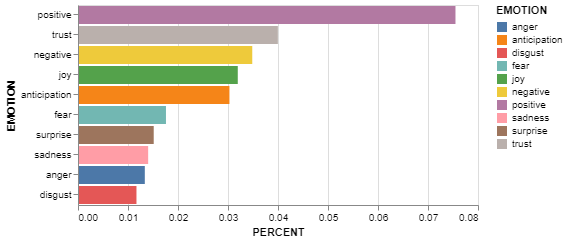

In [140]:
alt.Chart(result).mark_bar().encode(
     x='PERCENT:Q',
     y=alt.Y(
        'EMOTION:N',
        sort=alt.EncodingSortField(field='PERCENT', op='count', order='ascending')
        ),
    color='EMOTION:N',
    tooltip='PERCENT:Q'
    )


In [ ]:
input_dropdown = alt.binding_select(options= top_critics['critic'])
selection = alt.selection_single(fields=['critic'], bind=input_dropdown, name='Critic of ')
color = alt.condition(selection,
                    alt.Color('critic:N', legend=None),
                    alt.value('lightgray'))

alt.Chart(cars).mark_point().encode(
    x='Horsepower:Q',
    y='Miles_per_Gallon:Q',
    color=color,
    tooltip='Name:N'
).add_selection(
    selection
)

In [ ]:
## There are some problem about interactive issues, need to fix latter 
# print('Pleas eneterthe Critic name that you are interested in: ')
# criticname=str(input())
# analyze_quote(movie_review,criticname)

## Potential Analysis 

### Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

In [ ]:
reviewer_reviews=pd.DataFrame(reviews.groupby(['critic']).count().reset_index().sort_values('fresh'))

In [ ]:
# enter your code here  
%matplotlib inline  
import matplotlib.pyplot as plt 
reviewer_reviews=pd.DataFrame(reviews.groupby('critic').count())
reviewer_reviews.reset_index(level=0, inplace=True)
fig, ax = plt.subplots()
plt.xlim([0, 30])
plt.yscale('log', nonposy='clip')
ax.hist(reviewer_reviews.quote, range=[0,30],bins=30,color=['green'],edgecolor = 'white',alpha=0.5)
plt.ylabel('Logarithm of (count of) the Number of Reviews') # add labels 
plt.xlabel('Number of Reviews')
plt.title(' The histogram of reviews per reviewer')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(['Number of Reviewers'])
plt.show()

###  Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [ ]:
import time
from datetime import date

In [ ]:
reviews.dtypes

In [ ]:
reviews['review_date'] = pd.to_datetime(reviews['review_date'])

reviews['year'] = reviews['review_date'].dt.year
Group_Aggregation = reviews[['critic', 'publication', 
                       'year', 'quote']].groupby(['critic','year']).agg({ 
                         'quote': ['count']}).reset_index()
# Group_Aggregation['review_date'] = pd.to_datetime(Group_Aggregation['review_date'])

Group_Aggregation = Group_Aggregation[(Group_Aggregation['year'] == 2001)]
# Group_Aggregation = Group_Aggregation[(Group_Aggregation['review_date']<'2001-12-31')& (Group_Aggregation['review_date']>'2001-01-01')]
Group_Aggregation.sort_values(by=[('quote','count')], ascending = False)[:10]
# TOP_30_Critics=Group_Aggregation.sort_values(by=[('quote','count')], ascending = False)[:30]
# TOP_30_Critics.reset_index(level=0, inplace=True)

In [ ]:
# Group_Aggregation = reviews[['critic', 'publication', 
#                        'review_date', 'quote']].groupby('critic').agg({'review_date': ['max', 'min'], 
#                         'publication': ['max'], 'quote': ['count']}).reset_index()
# TOP_30_Critics=Group_Aggregation.sort_values(by=[('quote','count')], ascending = False)[:30]
# TOP_30_Critics.reset_index(level=0, inplace=True)
# TOP_30_Critics

### Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

In [ ]:
movies.head(2)

In [ ]:
# set the size of the figure 
plt.figure(figsize=(20,15))
# drop movies with 0
movies['rtAllCriticsRating'] = movies['rtAllCriticsRating'].apply(lambda x: x if x >0 else None)
# do the scatter plot 
sctr = plt.scatter(movies['year'], movies['rtAllCriticsRating'], c='blue', s=60)
sctr.set_alpha(0.3)
# calculate the average rating by year 
year_rating= pd.DataFrame(movies.groupby('year')['year'].count())
year_rating.columns = ['count']
year_rating['sumRating'] = movies.groupby('year')['rtAllCriticsRating'].sum()
year_rating['avgRating'] = year_rating['sumRating']/year_rating['count']
year_rating.reset_index(level=0, inplace =True)
year_rating = year_rating.dropna()
#  plot a trend in average rating over the year
plt.plot(year_rating['year'],year_rating['avgRating'], c='#6b00b3', color='orange',linewidth=3.0, marker='o', label='Average rating')
plt.legend()
plt.title('Movie ratings distribution and tendency by year(xaxis)')